In [1]:
import music21 as m21
import os
from GridMLM_tokenizers import CSGridMLMTokenizer
import numpy as np
from generate_utils import overlay_generated_harmony
import matplotlib.pyplot as plt
from tqdm import tqdm

/home/maximos/miniconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = '/media/maindisk/data/hooktheory_midi_hr/CA_train/'
# data_dir = '/media/maindisk/data/gjt_melodies/gjt_CA/'
data_files = []
for dirpath, _, filenames in os.walk(data_dir):
    for file in filenames:
        if file.endswith('.mid') or file.endswith('.midi') or file.endswith('.mxl') or file.endswith('.xml'):
            full_path = os.path.join(dirpath, file)
            data_files.append(full_path)
print(len(data_files))

14676


In [3]:
tokenizer = CSGridMLMTokenizer(fixed_length=80, quantization='4th')

In [4]:
print(data_files[31])
x = tokenizer.encode( data_files[31] )
print(x['input_tokens'])
print(x['pianoroll'].shape)

/media/maindisk/data/hooktheory_midi_hr/CA_train/18532_val_dubstep-pluck-tutorial_verse.mid
['<bar>', 'A:min', 'A:min', 'A:min', 'A:min', 'A:min', 'A:min', '<bar>', 'A:min', 'A:min', 'A:min', 'A:min', 'A:min', 'A:min', '<bar>', 'F:maj', 'F:maj', 'F:maj', 'F:maj', 'F:maj', 'F:maj', '<bar>', 'F:maj', 'F:maj', 'F:maj', 'F:maj', 'F:maj', 'F:maj', '<bar>', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', '<bar>', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', '<bar>', 'A:maj', 'A:maj', 'A:maj', 'A:maj', 'A:maj', 'A:maj', '<bar>', 'A:maj', 'A:maj', 'A:maj', 'A:maj', 'A:maj', 'A:maj', '<bar>', 'A:min', 'A:min', 'A:min', 'A:min', 'A:min', 'A:min', '<bar>', 'A:min', 'A:min', 'A:min', 'A:min', 'A:min', 'A:min', '<bar>', 'F:maj', 'F:maj', 'F:maj', 'F:maj', 'F:maj', 'F:maj', '<bar>', 'F:maj', 'F:maj']
(80, 101)


In [5]:
# x = tokenizer.encode( 'example_inputs/test_midi_constraints.mid', keep_durations=True )
x = tokenizer.encode( data_files[0], keep_durations=True )
print(x['input_tokens'])
print(len(x['input_tokens']))
print(x.keys())
print(x['skip_steps'])
print(x['ql_per_quantum'])
print(x['pianoroll'].shape)
print(x['harmonic_rhythm_density'])
print(x['harmonic_complexity'])
print(x['h_density_complexity'])
harm_string = '_'.join( x['input_tokens'] )
# print(gen_harm)
harm_bars = harm_string.split( '<bar>_' )
for h in harm_bars:
    print(h)

['<bar>', 'A:min', 'A:min', 'E:maj', 'E:maj', '<bar>', 'C:maj', 'C:maj', 'E:maj', 'E:maj', '<bar>', 'A:min', 'A:min', 'E:maj', 'E:maj', '<bar>', 'C:maj', 'C:maj', 'E:maj', 'E:maj', '<bar>', 'D:min', 'D:min', 'E:maj', 'E:maj', '<bar>', 'A:min', 'A:min', 'C:maj', 'C:maj', '<bar>', 'E:maj', 'E:maj', 'E:maj', 'E:maj', '<bar>', 'D:min', 'D:min', 'G:maj', 'G:maj', '<bar>', 'C:maj', 'C:maj', 'C:maj', 'C:maj', '<bar>', 'F:maj', 'F:maj', 'F:maj', 'F:maj', '<bar>', 'F:min', 'F:min', 'F:min', 'F:min', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
80
dict_keys(['input_tokens', 'input_ids', 'pianoroll', 'time_signature', 'attention_mask', 'skip_steps', 'melody_part', 'ql_per_quantum', 'back_interval', 'harmonic_rhythm_density', 'harmonic_complexity', 'h_density_complexity'])
0
1
(80, 101)
1.6363636363636365
1.9886167437823

In [6]:
def apply_focal_sharpness(
        melody_grid,
        target_indices,
        focal_sharpness,
        min_sigma=0.5,
        max_sigma=5.0
    ):
    """
    Apply Gaussian attenuation around a focal index per sequence.
    
    Args:
        melody_grid: [B, L, dm] tensor (batch of pianorolls)
        target_indices: [B, 1] tensor with focal indices in [0, L-1]
        focal_sharpness: [B, 1] tensor with values in [0,1]
        min_sigma, max_sigma: range for Gaussian variance mapping
    
    Returns:
        attenuated_grid: [B, L, dm] tensor
    """
    B, L, dm = melody_grid.shape

    # Map sharpness [0,1] -> sigma [max_sigma, min_sigma]
    # low sharpness = wide Gaussian (large sigma), high sharpness = narrow Gaussian (small sigma)
    sigma = max_sigma - focal_sharpness * (max_sigma - min_sigma)  # [B,1]

    # Create positions [0..L-1]
    positions = torch.arange(L, device=melody_grid.device).unsqueeze(0).expand(B, L)  # [B, L]

    # Expand focal indices
    # make sure that target_indices is the correct shape
    if target_indices.dim() == 1:          # shape [B]
        target_indices = target_indices.unsqueeze(-1)  # [B,1]
    elif target_indices.dim() == 2 and target_indices.shape[0] == 1:  
        # case: [1,B] -> transpose to [B,1]
        target_indices = target_indices.t()
    focal = target_indices.expand(-1, L)  # [B, L]

    # Compute squared distance
    dist2 = (positions - focal).float() ** 2  # [B, L]

    # Compute Gaussian weights: exp(-d^2 / (2σ^2))
    weights = torch.exp(-dist2 / (2 * sigma**2))  # [B, L]

    # Normalize weights (optional, keeps focal=1 and remote->0 without collapsing scale)
    weights = weights / weights.max(dim=1, keepdim=True).values

    # Expand to match pianoroll dims
    weights = weights.unsqueeze(-1)  # [B, L, 1]

    # Apply attenuation
    attenuated_grid = melody_grid * weights

    return attenuated_grid
# end apply_focal_sharpness

In [8]:
import torch

In [65]:
pr_old = torch.Tensor(x['pianoroll']).reshape(1, 80,101)
target_indices = torch.Tensor([10]).reshape(1,1)
focal_sharpness = torch.Tensor([0.9]).reshape(1,1)
print(pr_old.shape)
print(target_indices.shape)
print(focal_sharpness.shape)

torch.Size([1, 80, 101])
torch.Size([1, 1])
torch.Size([1, 1])


In [66]:
pr = apply_focal_sharpness(pr_old, target_indices, focal_sharpness, min_sigma=1.0, max_sigma=40.0)

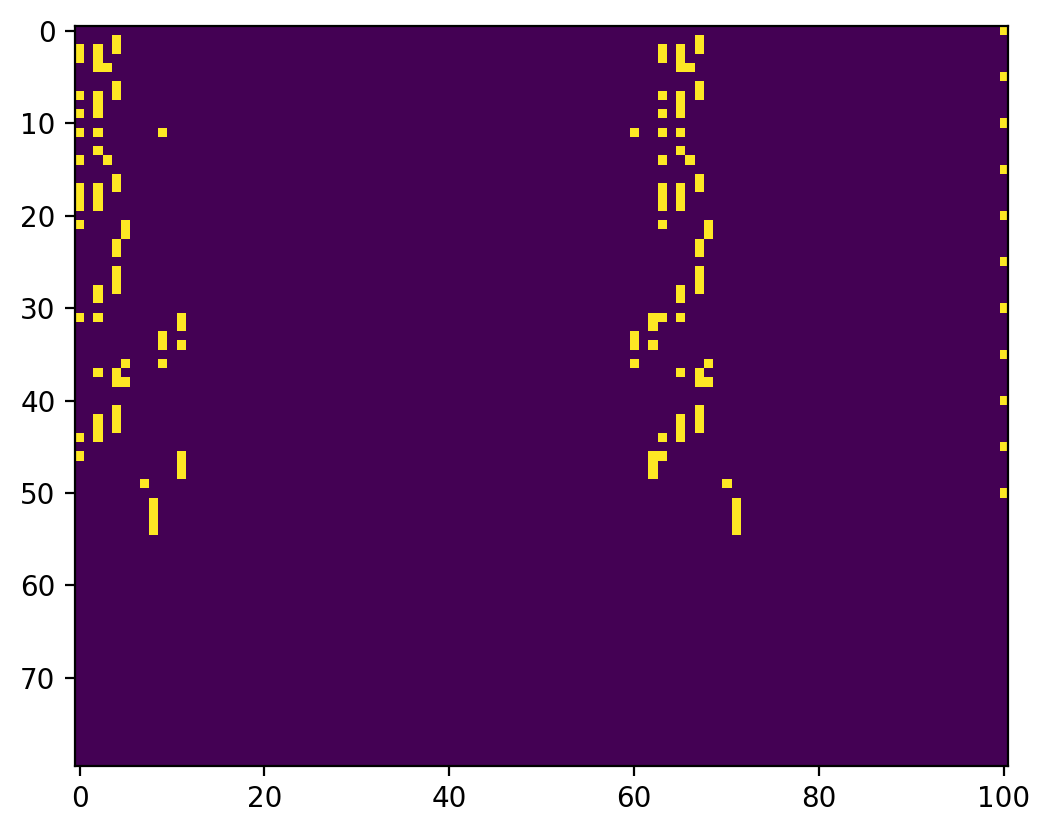

In [60]:
plt.imshow(x['pianoroll'][:,:])

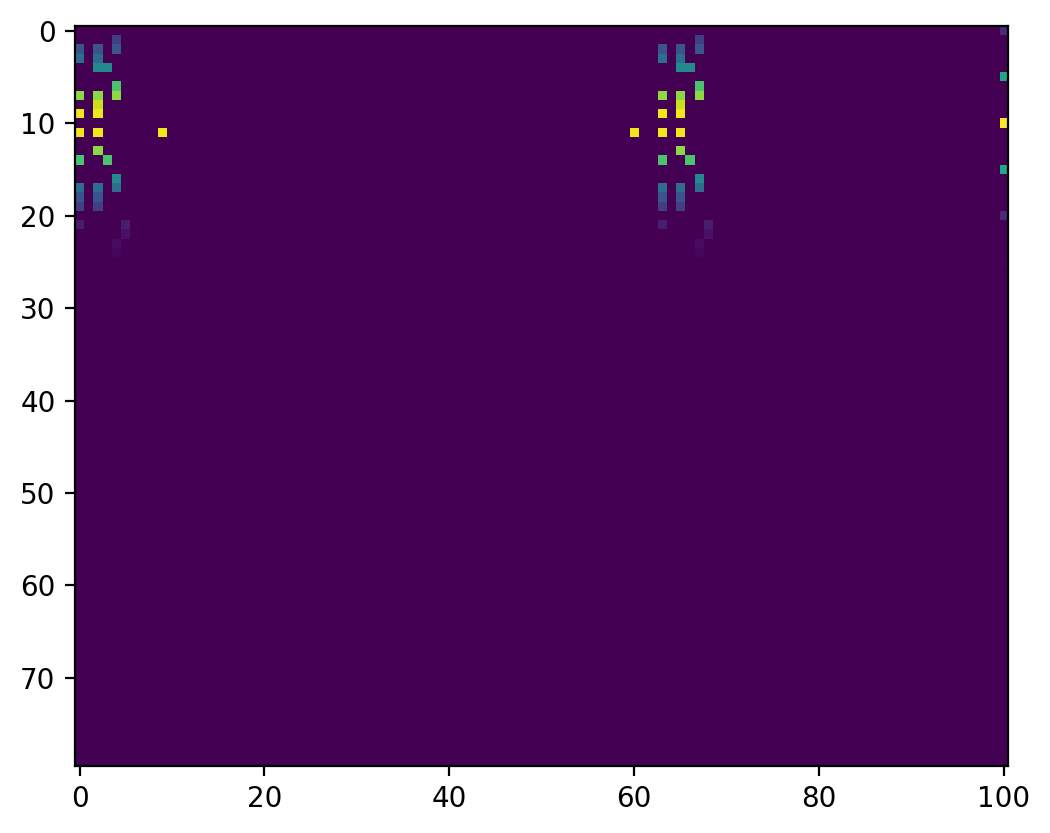

In [67]:
plt.imshow(pr.reshape(80,101))

In [10]:
s = overlay_generated_harmony(x['melody_part'], x['input_tokens'], x['ql_per_quantum'], x['skip_steps'])
s.show('t')

{0.0} <music21.stream.Part 0x7ec1fa1430b0>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.tempo.MetronomeMark andantino Quarter=79>
        {0.0} <music21.meter.TimeSignature 4/4>
        {0.0} <music21.note.Note E>
        {1.5} <music21.note.Note D>
        {1.75} <music21.note.Note C>
        {2.0} <music21.note.Note D>
        {2.25} <music21.note.Note C>
        {2.5} <music21.note.Note D>
        {2.75} <music21.note.Note C>
        {3.0} <music21.note.Note D>
        {3.75} <music21.note.Note E->
    {4.0} <music21.stream.Measure 2 offset=4.0>
        {0.0} <music21.note.Note E>
        {1.25} <music21.note.Note D>
        {1.5} <music21.note.Note C>
        {2.0} <music21.note.Note D>
        {2.5} <music21.note.Note D>
        {3.0} <music21.note.Note C>
        {3.5} <music21.note.Note D>
    {8.0} <music21.stream.Measure 3 offset=8.0>
        {0.0} <music21.note.Note D>
        {0.25} <music21.note.Note C>
     

/home/maximos/miniconda3/envs/torch/lib/python3.12/site-packages/music21/base.py:559: UserWarning: Setting an ID that could be mistaken for a memory location is discouraged: got 139371623994320
  warnings.warn(msg)


In [20]:
# stats on harmonic rhythm density and complexity
h_rhythm = []
h_complexity = []
for i in tqdm(range(min(len(data_files) , 1000))):
    x = tokenizer.encode( data_files[1000 + i] )
    h_rhythm.append(x['harmonic_rhythm_density'])
    h_complexity.append(x['harmonic_complexity'])

  6%|▌         | 56/1000 [00:01<00:28, 32.96it/s]


KeyboardInterrupt: 

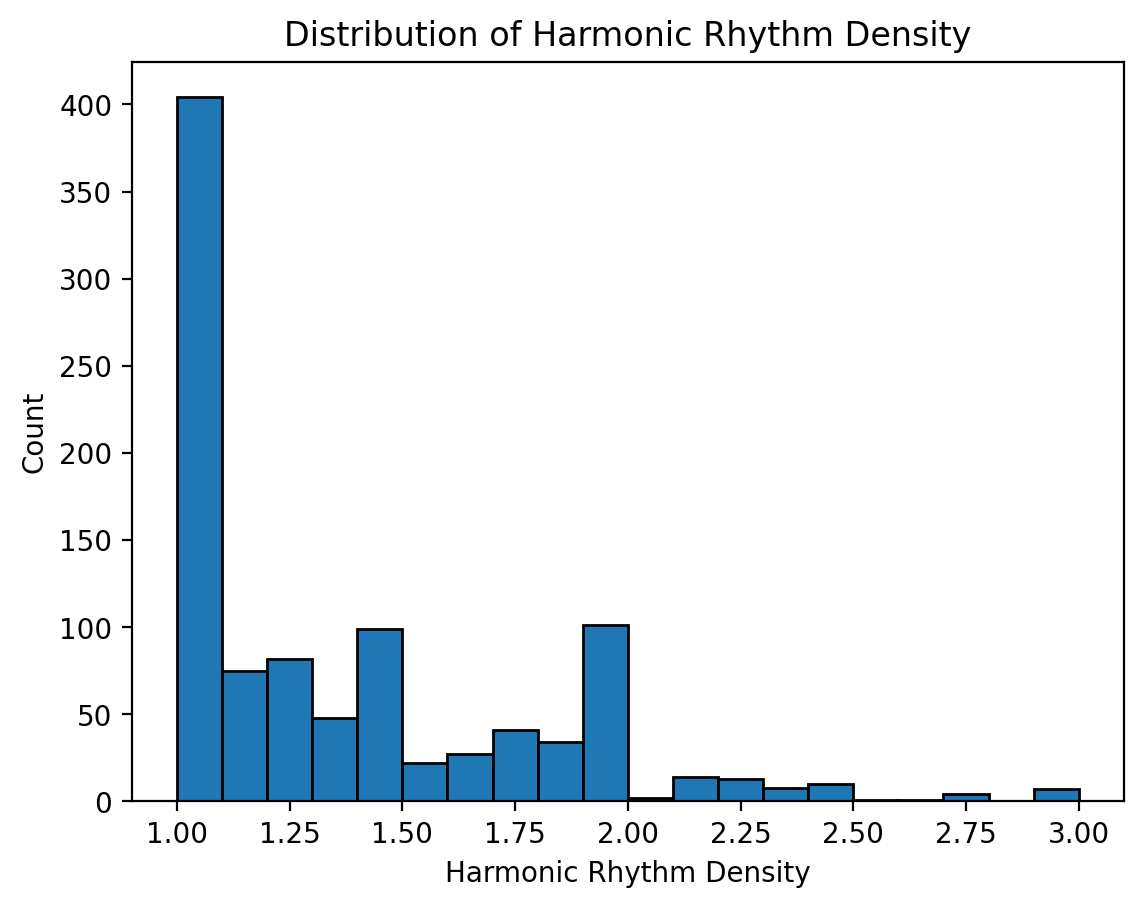

In [14]:
bins = np.arange(1, 3.1, 0.1)  # bins from 1 to 3 with step 0.1
plt.hist(h_rhythm, bins=bins, edgecolor='black')
plt.xlabel('Harmonic Rhythm Density')
plt.ylabel('Count')
plt.title('Distribution of Harmonic Rhythm Density')
plt.show()

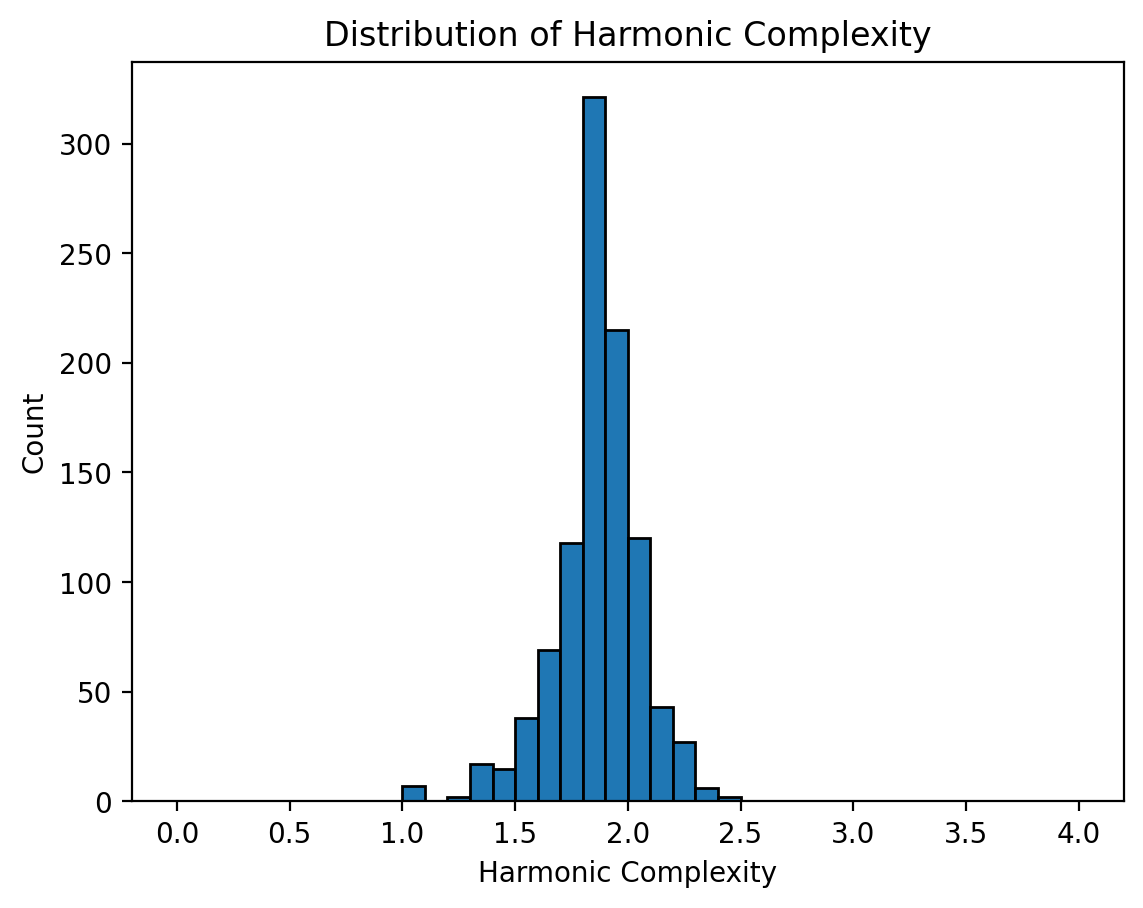

In [15]:
bins = np.arange(0, 4.1, 0.1)  # bins from 0 to 4 with step 0.1
plt.hist(h_complexity, bins=bins, edgecolor='black')
plt.xlabel('Harmonic Complexity')
plt.ylabel('Count')
plt.title('Distribution of Harmonic Complexity')
plt.show()

In [16]:
# Compute 1/3 and 2/3 quantiles
rhythm_thresholds = np.quantile(h_rhythm, [1/3, 2/3])
complexity_thresholds = np.quantile(h_complexity, [1/3, 2/3])

print("Rhythm thresholds:", rhythm_thresholds)
print("Complexity thresholds:", complexity_thresholds)

# Example: map values to categories
def to_category(x, thresholds):
    if x < thresholds[0]:
        return "low"
    elif x < thresholds[1]:
        return "medium"
    else:
        return "high"

# Apply to arrays if you want labels
rhythm_labels = [to_category(v, rhythm_thresholds) for v in h_rhythm]
complexity_labels = [to_category(v, complexity_thresholds) for v in h_complexity]


Rhythm thresholds: [1.  1.5]
Complexity thresholds: [1.82946262 1.92258824]


In [17]:
s.show('t')

{0.0} <music21.stream.Part 0x7ff4653339e0>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.tempo.MetronomeMark andante moderato Quarter=85>
        {0.0} <music21.meter.TimeSignature 4/4>
        {0.0} <music21.note.Note E>
        {0.5} <music21.note.Note E>
        {1.0} <music21.note.Note E>
        {1.5} <music21.note.Note E>
        {2.5} <music21.note.Rest eighth>
        {3.0} <music21.note.Note C>
        {3.5} <music21.note.Note D>
    {4.0} <music21.stream.Measure 2 offset=4.0>
        {0.0} <music21.note.Note E>
        {0.5} <music21.note.Note E>
        {1.0} <music21.note.Note C>
        {1.5} <music21.note.Note E>
        {2.0} <music21.note.Note D>
        {3.0} <music21.note.Rest eighth>
        {3.5} <music21.note.Note C>
    {8.0} <music21.stream.Measure 3 offset=8.0>
        {0.0} <music21.note.Note D>
        {0.5} <music21.note.Note D>
        {1.0} <music21.note.Note D>
        {1.5} <music21.note.Not

In [18]:
m = m21.converter.parse('example_inputs/test_midi_constraints.mid')

In [19]:
p1 = m.parts[1]
c1 = p1.chordify()
f1 = c1.flatten()
p1.show('t')
c1.show('t')
f1.show('t')

{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Piano 'Piano, Piano: Piano, Piano'>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.key.Key of G major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Rest whole>
{4.0} <music21.stream.Measure 2 offset=4.0>
    {0.0} <music21.note.Rest whole>
{8.0} <music21.stream.Measure 3 offset=8.0>
    {0.0} <music21.note.Rest whole>
{12.0} <music21.stream.Measure 4 offset=12.0>
    {0.0} <music21.note.Rest half>
    {2.0} <music21.chord.Chord D3 F#3 A3>
{16.0} <music21.stream.Measure 5 offset=16.0>
    {0.0} <music21.note.Rest whole>
{20.0} <music21.stream.Measure 6 offset=20.0>
    {0.0} <music21.note.Rest whole>
{24.0} <music21.stream.Measure 7 offset=24.0>
    {0.0} <music21.stream.Voice 0x7ff4648904a0>
        {0.0} <music21.note.Note G>
        {0.75} <music21.note.Rest 3.25ql>
    {0.0} <music21.stream.Voice 0x7ff464c448f0>
        {0.0} <music21.chord.Chord C3 E3>
        {3.75} <music21.note